In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest

In [149]:
x_train = pd.read_csv('x_train_wav2.csv')
y_train = pd.read_csv('y_train_wav2.csv')
x_test = pd.read_csv('x_test_wav2.csv')
y_test = pd.read_csv('y_test_wav2.csv')

def remove_outliers_iforest(X, y, frac=0.05, random_state=42):
    iso = IsolationForest(contamination=frac, random_state=random_state)
    preds = iso.fit_predict(X)
    # preds == -1 → outlier; preds == 1 → inlier
    mask = preds == 1

    X_clean = X[mask]
    y_clean = np.array(y)[mask]

    if isinstance(y, pd.DataFrame):
        y_clean = pd.DataFrame(y_clean, columns=y.columns)
    if isinstance(X, pd.DataFrame):
        X_clean = pd.DataFrame(X_clean, columns=X.columns)
    return X_clean, y_clean, mask

# Example usage:
# x_train, y_train, inlier_mask = remove_outliers_iforest(x_train, y_train, frac=0.02)

classes = y_test["emotion"].unique()
print(f"Classes: {classes}")

Classes: ['negative' 'neutral' 'positive']


In [150]:
etc = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

etc.fit(x_train, y_train["emotion"])

importances = etc.feature_importances_

sorted_importances = np.sort(importances)[::-1]
cumulative_importances = np.cumsum(sorted_importances)
threshold_index = np.searchsorted(cumulative_importances, 0.1)
threshold_value = sorted_importances[threshold_index]

selector_model = SelectFromModel(etc, threshold=threshold_value, prefit=True)

selected_features = x_train.columns[selector_model.get_support()]

c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

    negative       0.68      0.67      0.68       433
     neutral       0.54      0.58      0.56       161
    positive       0.41      0.38      0.40       190

    accuracy                           0.59       784
   macro avg       0.54      0.55      0.54       784
weighted avg       0.58      0.59      0.58       784



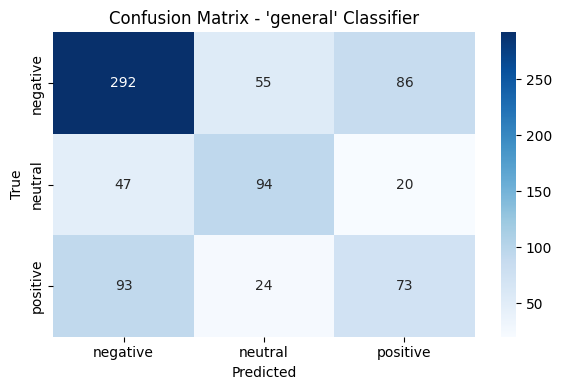

In [151]:
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    random_state=42
)

general_pipeline = Pipeline([
    ("selector", selector_model),
    ("mlp", mlp)
])

general_pipeline.fit(x_train, y_train)

y_pred = general_pipeline.predict(x_test)
y_pred_proba = general_pipeline.predict_proba(x_test)

print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

    negative       0.75      0.52      0.61       433
     neutral       0.51      0.79      0.62       161
    positive       0.40      0.50      0.45       190

    accuracy                           0.57       784
   macro avg       0.55      0.60      0.56       784
weighted avg       0.62      0.57      0.57       784



Text(0.5, 1.0, "Confusion Matrix - 'svm' Classifier")

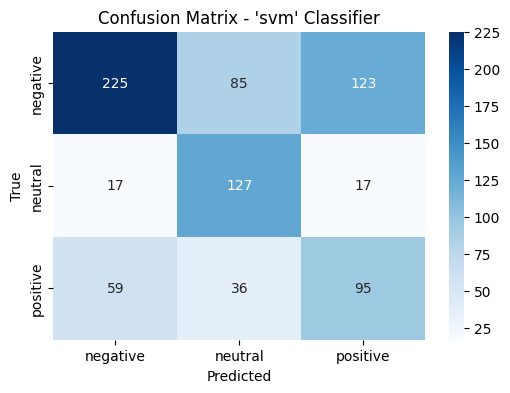

In [152]:
# Train balanced SVC
svc = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm_pipeline = Pipeline([
    ("selector", selector_model),
    ("svm", svc)
])

svm_pipeline.fit(x_train, y_train["emotion"])
y_pred = svm_pipeline.predict(x_test)
y_pred_proba = svm_pipeline.predict_proba(x_test)
print(classification_report(y_test, y_pred, target_names=classes))
cm = confusion_matrix(y_test, y_pred)
# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'svm' Classifier")

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       879
     neutral       0.86      0.87      0.87       326
    positive       0.87      0.74      0.80       385

    accuracy                           0.86      1590
   macro avg       0.86      0.84      0.85      1590
weighted avg       0.86      0.86      0.86      1590



Text(45.722222222222214, 0.5, 'True')

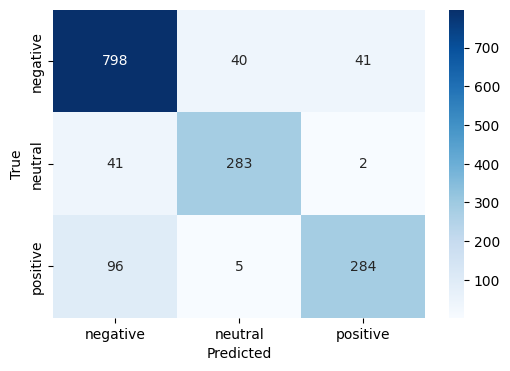

In [153]:
#joblib.dump(mlp, 'general_mlp_model.pkl')
overfitTest = general_pipeline.predict(x_train)
overfitTestProba = general_pipeline.predict_proba(x_train)
print(classification_report(y_train, overfitTest, target_names=classes))

cm = confusion_matrix(y_train, overfitTest)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")